In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns ;sns.set()

In [2]:
df = pd.read_csv('../Data/CleanData/InitialClean.csv',dtype='object',index_col=0)
df.columns

Index(['APGAR1', 'APGAR2', 'AREA', 'AREA_RESIDENCIA_HAB', 'ASIS_MED',
       'CAUSA_667', 'CAU_HOMOL', 'CERT_EXPEDIDO_POR', 'COD_DPTO', 'C_BAS1',
       'C_DIR1', 'DEPTO_RESIDENCIA', 'EDAD_MADRE', 'EDAD_PADRE', 'EST_CIVM',
       'FECHA_NACM', 'GRU_ED1', 'IDADMISALUD', 'IDCLASADMI', 'IDFACTORRH',
       'IDHEMOCLAS', 'IDPERTET', 'MANERA_MUERTE', 'MOMENTO_MUERTE', 'NIV_EDUM',
       'NIV_EDUP', 'NUM_CONSUL', 'N_EMB', 'N_HIJOSM', 'N_HIJOSV', 'NacidoVivo',
       'PAIS_RESIDENCIA', 'PARTO_ATENDIDO_POR', 'PESO', 'PROFESION',
       'RESULTADO_EMB', 'SEG_SOCIAL', 'SEXO', 'SITIO_EVENTO', 'TALLA',
       'TIEMPO_GESTACION', 'TIPO_EMBARAZO', 'TIPO_PARTO', 'ULTCURMAD',
       'ULTCURPAD', 'ID_BIRTH', 'ID_RESID', 'ID_VIOL', 'C_MUERTE', 'DATE'],
      dtype='object')

## Start looking at some seemingly easy to understand variables:

PESO, AREA_RES, EDAD_MADRE, SEXO, TALLA, T_GES

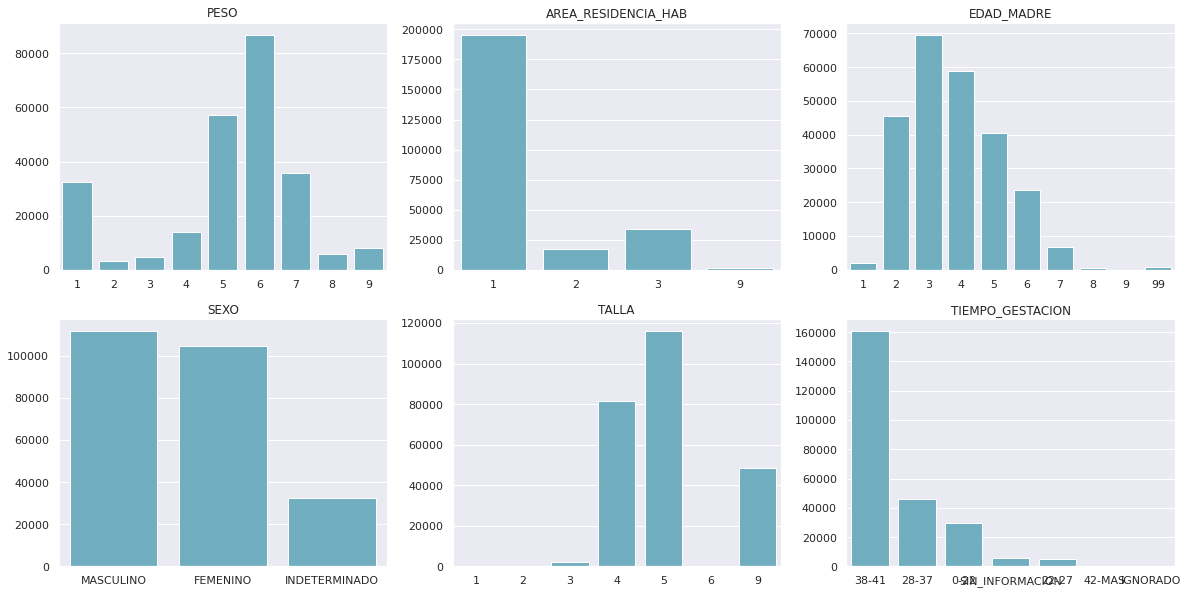

In [4]:
cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    axi.set_title(col)
    cnt_peso = df[col].value_counts()
    sns.barplot(cnt_peso.index,cnt_peso.values,ax=axi,color='c')
    
plt.savefig('../Plots/InitialDists.png')
plt.show()

PESO has quite an interesting distribution. It looks normal if we exclude 1 and 9, but 1 is a large peak. It may be related to underweighting. There is also the fact that 1 represents the 0-1000 g range, while every other number represents a 500 g range. Even then, it is still a prominent peak.

EDAD_MADRE is skewed to the right, with the peak at 3 (20-24 yo). It is worrying the quantity of pregnancies from 10-14 yo (bin 1). The range 15-19 is also quite large.

Also, most of the births occur at municipal headers (1), SEXO is almost 50/50.

T_GES: Has peaks at 1 and 4 (<22 weeks, 38-41 weeks). The latter is about the normal time of a pregnancy, but the first roughly indicates the quantity of early deliveries. It would be interesting to study the influence of this variable on viability of newborn.

Most of the TALLA are missing, so it probably is not a very informative variable.

In [ ]:
#pedro

## Now let us discriminate distributions.

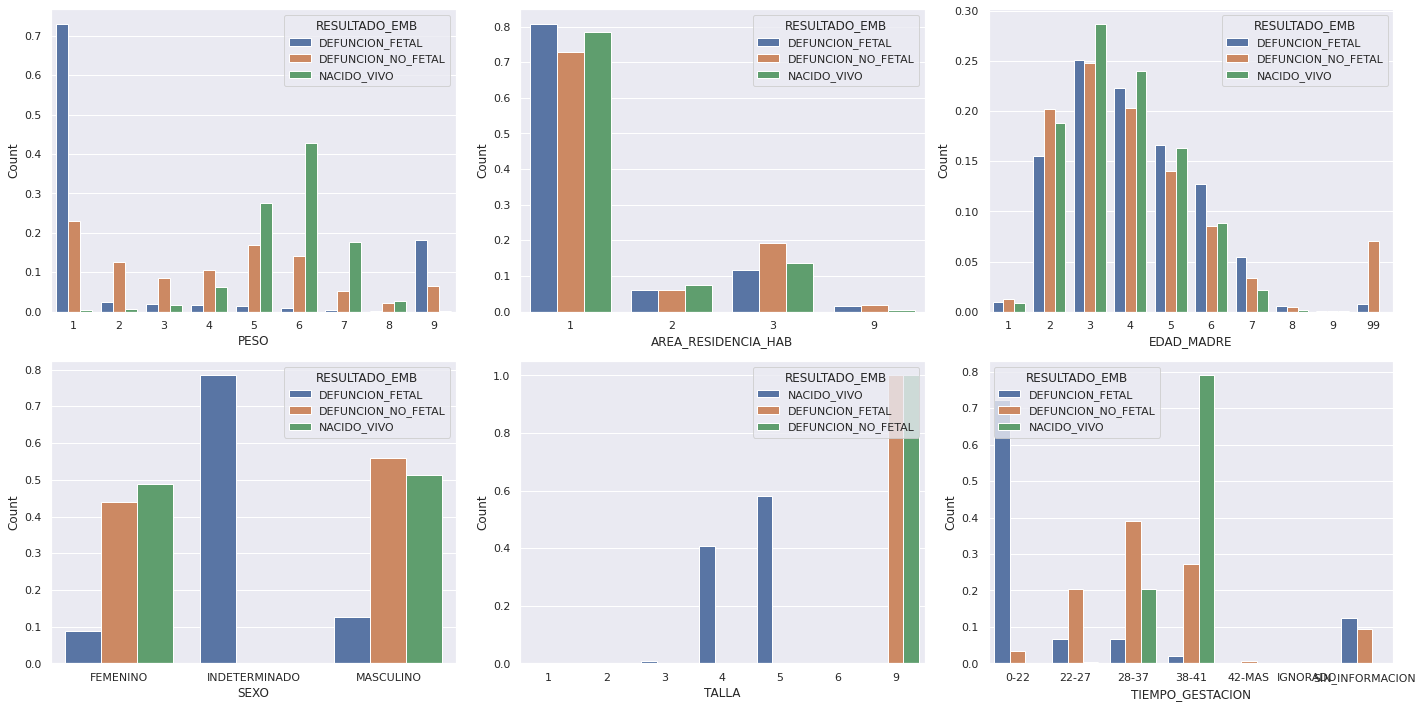

In [11]:
cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df[[col,'RESULTADO_EMB']]
                .groupby([col,'RESULTADO_EMB'])
                .apply(len).reset_index()
                .rename(columns={0:'Count'}))

    #Compute normalized distribution
    totals =  cnt.groupby('RESULTADO_EMB').apply(sum).Count  #Total elements
    for ind in totals.index:
        cnt.loc[cnt['RESULTADO_EMB']==ind,'Count'] /= totals[ind]
    
    sns.barplot(data=cnt,x=col,y='Count',hue='RESULTADO_EMB',ax=axi)
    
plt.tight_layout()
plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()

The first plot explains the observations on the above cells: The PESO distribution of the newborns IS normal, the peak at 1 is due almost exclusively to fetal deaths (orange). A small peak (green) cal also be seen here, which probably makes PESO a good factor indicating newborn viability. AREA and EDAD_MADRE have very similar distributions. 

From these plots we can start identifying correlations (at least to proof the consistency of the data). We can see that the peak at 3 in SEXO (undetermined) is exclusively due to fetal deaths. From the T_GES plot we can see that most of the fetal deaths occur before 22 weeks. Depending on the time of differentiation of sex, this correlation may be due to the lack of differentiation at the time of the death of these fetuses.

There might be some correlation between TALLA and T_GES. There are two similar peaks in both of the plots, which may indicate some correspondence.

There doesn't seem to be substantial differences among distributions in AREA_RES, that is, the fact that some mother lives at a city or in a rural place doesn't seem to determine whether the fetus lives or dies.

An additional (and more subtle) insight: in the EDAD_MADRE plot we can see that the distribution for fetal deaths is a bit more spread out than that for the newborns. What this means is that older women do get pregnant, but the probability of them having an abortion increases.

# Questions (check the boxes as you answer questions)

- [x] Do APGAR{1,2} actually predict anything?
- [x] Is there any difference between newborns whose mothers reside in a different place where the kids are born (ID_BIRTH != ID_RESID)?
- [ ] Is the distribution of ages of the fathers different from that of the mothers? Discriminate between newborn, deaths, etc. See if there's any correlation.
- [ ] Look at GRU_ED1. How is the distribution of ages of newborn deaths?
- [ ] WTF is IDADMISALUD?
- [ ] IDPERTET is cultural-racial identification. Are distributions any different?
- [ ] Influence of MUL_PARTO
- [ ] Compare NIV_EDUM, NIV_EDUP. Are these distributions any different? Look for combinations of these two, maybe data can already show inequity?
- [ ] N_EMB, N_HIJOSM, N_HIJOSV on outcome. Distribution, geographical distribution, correlation with race, culture, age
- [ ] Eliminate OCUPACION (check first)
- [ ] Look at SITIO_EVENTO. Make data cleaning worth it!
- [ ] Corr with TIPO_PARTO

I guess that's it for now

### Q1: Do APGAR{1,2} actually predict anything?

Number of 99s: 109089


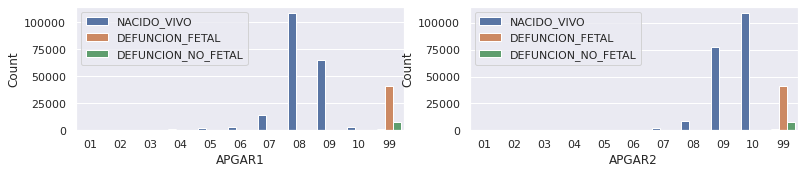

In [9]:
#Let's first look at APGAR{1,2}

#Check for 99s. They should appear ONLY for fetal deaths.
num99s = df['APGAR1'].value_counts().iloc[0]
print(f"Number of 99s: {num99s}")

cols = ['APGAR1','APGAR2']

fig = plt.figure(figsize=(20,5))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df[['RESULTADO_EMB',col]]
            .groupby([col,'RESULTADO_EMB'])
            .apply(len).reset_index().rename(columns={0:'Count'}))
    sns.barplot(data=cnt,x=col,y='Count',hue='RESULTADO_EMB')
    plt.legend(loc=2)

So, it turns out both fetal and non-fetal deaths datasets are full of 99s on these columns, so we can't predict anything. We can, however, look a the distribution of this variable.

For what can be seen from these plots, it looks like a higher APGAR value is more common (and I guess better because these kids were atually born alive)

### Q2: Is there any difference between newborns whose mothers reside in a different place where the kids are born (ID_BIRTH != ID_RESID)?

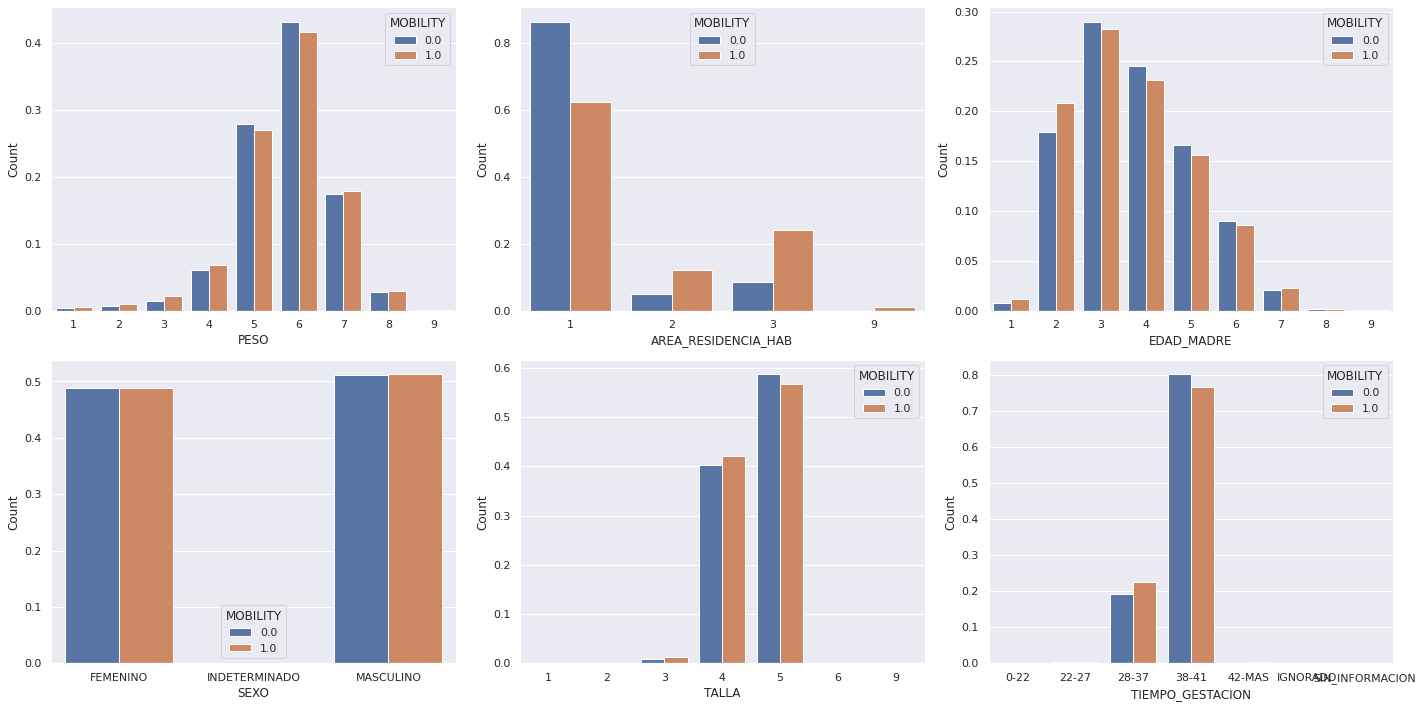

In [12]:
#Create new column for this variable.
#Actually we'd have to segregate those whose death was violent but lets do it like this for now.
df['MOBILITY'] = (df['ID_BIRTH'] != df['ID_RESID'])*1.0

cols = ['PESO','AREA_RESIDENCIA_HAB','EDAD_MADRE','SEXO','TALLA','TIEMPO_GESTACION']

fig = plt.figure(figsize=(20,10))
for i,col in enumerate(cols):
    axi = fig.add_subplot(2,3,i+1)
    cnt = (df.loc[df['RESULTADO_EMB']=='NACIDO_VIVO',[col,'MOBILITY']]
                .groupby([col,'MOBILITY'])
                .apply(len).reset_index()
                .rename(columns={0:'Count'}))
    #Compute normalized distribution
    totals =  cnt.groupby('MOBILITY').apply(sum).Count  #Total elements
    for ind in totals.index:
        cnt.loc[cnt['MOBILITY']==ind,'Count'] /= totals[ind]
    
    sns.barplot(data=cnt,x=col,y='Count',hue='MOBILITY',ax=axi)
    
plt.tight_layout()
#plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()

The insight here is that mothers that travel in order to give birth usually come from rural areas (which is not really surprising though). Every other distribution behaves practically the same.

Also, from plot 3 it can be seen that most of the 10-19 yo mothers have to move from their place of residence in order to give birth. These two observations lead us to conjecture that teenage pregnancies are more common in rural areas. Can this information be extracted from the data?

### Q3: Is the distribution of ages of the fathers different from that of the mothers? Discriminate between newborn, deaths, etc. See if there's any correlation.

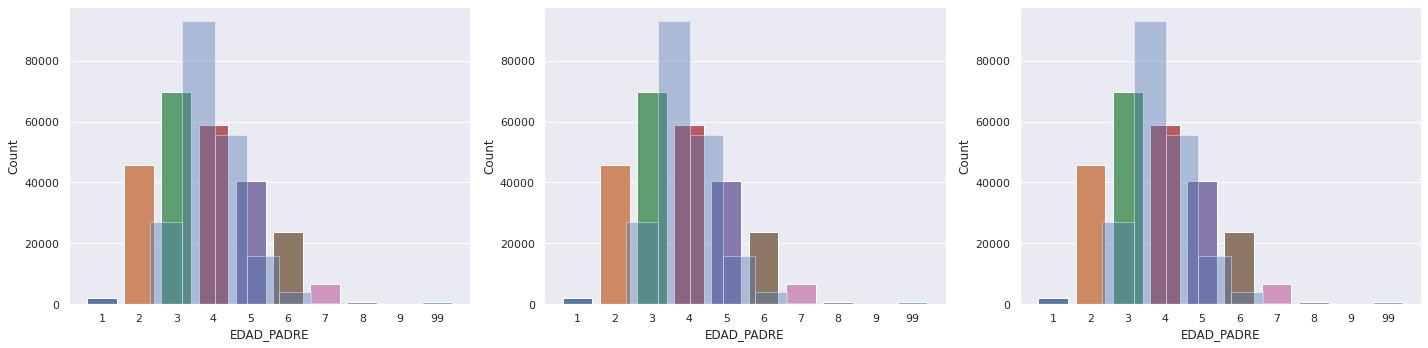

In [13]:
fig = plt.figure(figsize=(20,5))

for i,tipo in enumerate(df['RESULTADO_EMB'].unique()):
    dfn = df[['EDAD_MADRE','EDAD_PADRE']].astype(int).replace(999,np.nan)
    dfn['EDAD_PADRE'] /= 10
    cnt_mad = (dfn.groupby('EDAD_MADRE')
               .apply(len).reset_index()
               .rename(columns={0:'Count'}))

    axi = fig.add_subplot(1,3,i+1)
    sns.barplot(data=cnt_mad,x='EDAD_MADRE',y='Count',ax=axi)
    sns.distplot(dfn['EDAD_PADRE'],ax=axi,bins=9,kde=False)
    
    
plt.tight_layout()
#plt.savefig('../Plots/InitialDiscrimDists.png')
plt.show()